# Juggling RL project

## Install dependencies

In [ ]:
#!pip install gymnasium
#!pip install keras-rl
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

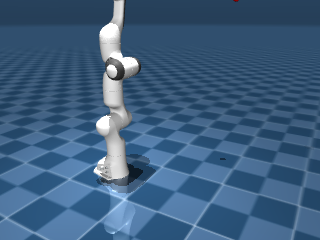

In [2]:
# Make model and data
model = mujoco.MjModel.from_xml_path("../robot/scene.xml")
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [5]:
duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

## Create the gym environment

In [ ]:
class JugglingEnv(gym.Env):
    
    def __init__(self, render_mode=None):
        
        # Observations
        
        #agent observation space is the position of the cup
        #target observation will be the concatenated positions of the two balls
        
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(low=, high=, shape=(3,), dtype=np.float32),
                "target": spaces.Box(0, size - 1, shape=(6,), dtype=np.float32)
            }
        )
        
        # action space is the control values of our actuators
        self.action_space = spaces.Box(low=np.array([-2.9,-1.76,-3.07]), high=np.array([2.9,1.76,3.07]), shape=(3,), dtype=np.float32)
        
        
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}
    
    #TODO write reset() step() close() render() _render_frame()
    # https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/#sphx-glr-tutorials-gymnasium-basics-environment-creation-py
    
    

In [2]:
import custom_gym
env = gym.make('Juggler')

NameNotFound: Environment Juggler doesn't exist. 

## Create a deep learning model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

## Keras RL agent

In [8]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [9]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)